## pyMETAflow for NMR

#### Overview
This notebook demonstrates a complete workflow for processing and analyzing NMR/metabolomics data.  The analysis leverages a custom module (data_processing_NMR.py) that contains functions for:

* **Data Extraction & Import:**  
  Reading NMR data exported from MNova, combining CSV files, and organizing the data.
  

* **Preprocessing:**  
  Filtering by chemical shift ranges, masking unwanted spectral regions, and removing unwanted samples.


* **Spectral Referencing & Alignment:**  
  Referencing spectra (e.g., aligning the reference peak at 0.0 ppm) and applying multiple alignment methods (ICOSHIFT, RAFFT, PAFFT) to ensure spectra are properly aligned.


* **Visualization:**  
  Generating interactive plots for the raw and processed spectra, including vertical multiplots and histograms.


* **STOCSY Analysis:**  
  Performing Statistical Total Correlation Spectroscopy (STOCSY) to explore covariance and correlation across the spectra.


* **Data Transformation, Normalization & Scaling:**  
  Applying log, square root, and cube root transformations along with several normalization (Z-score, PQN, etc.) and scaling (mean centering, Pareto, etc.) techniques.


* **Multivariate Analysis:**  
  Running Principal Component Analysis (PCA) and Partial Least Squares Discriminant Analysis (PLS-DA) for dimensionality reduction, group separation, and variable importance (VIP) evaluation.


* **Export:**  
  Preparing the processed data for further analysis in tools like MetaboAnalyst.



This notebook is organized into sections that follow the natural progression of data analysis—from data import and initial visualization to preprocessing, advanced alignment, multivariate analysis, and finally, reporting of the results.

### 1. Import Essential Libraries

In this section we load all the required libraries and modules. This includes standard packages (e.g., NumPy, Pandas, Matplotlib), machine learning and statistical tools (e.g., scikit-learn, seaborn), spectral alignment libraries (e.g., Icoshift), and interactive plotting tools (Plotly). We also import our custom data processing functions from data_processing_NMR.py.

In [ ]:
# Import essential libraries
import os
import os.path
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mc
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
import seaborn as sns

from pyicoshift import Icoshift
from scipy.io import loadmat

import plotly.io as pio
import plotly.graph_objects as go

import data_processing_NMR as dp


---
### 2. Setting the Working Directory and Data Import

Here, we set the working directory to the folder containing our data and metadata files. We then load the NMR data using our extraction functions. We also check the shape of the data and load the corresponding metadata.

In [ ]:
directory_path = r'C:\Users\borge\Downloads\Abril_2018\filtered'
os.chdir(directory_path)
%pwd

In [ ]:
# Import data
filename = "ST001945.csv"

# Change to the target directory (optional)
os.chdir(directory_path)

# Load and display the data
data = dp.extract_data_NMRMNova(os.path.join(directory_path, filename))
print(f"Data size: {data.shape}")
print(f"Data size (no axis): {(data.drop(columns='Chemical Shift (ppm)').shape)}")

#### Metadata import for group specifics

In [ ]:
# Create the Target Vector for the supervision tool (PLS-DA)
df_metadata = pd.read_csv("Metadata.csv", sep=",")
df_metadata.shape

---
### 3. Visualization of the Raw NMR Spectra

We plot the raw NMR spectra to inspect the quality and overall structure of the data. This initial visualization helps identify any artifacts or unwanted regions.

In [ ]:
dp.create_nmr_plot(data, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='nmr_spectra_overlapping.html',
                    show_fig=False)

---
### 4. Data Filtering and Masking

This section shows how to filter the spectra by chemical shift range and mask out unwanted regions. We:

* Clip the spectral region (e.g., between 0.5 and 10 ppm).
* Remove specific regions (e.g., solvent or interference peaks) by setting them to zero.

In [ ]:
# Define start and end for the region to zero out
start_limit = -0.5
end_limit = 10

# Remove regions
modified_df = dp.filter_chemical_shift(data, start_limit=start_limit, end_limit=end_limit)

dp.create_nmr_plot(modified_df, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='nmr_spectra_overlapping_filtered.html',
                    show_fig=False)

print(f"Spectrta was cliped between {start_limit} and {end_limit} ppm.")

In [ ]:
# Define start and end for the region to zero out
regions_to_mask = [(4.683,4.893), (3.32,3.38)]  # Define regions where values should be set to zero

filtered_df = dp.mask_regions_with_zeros(modified_df, regions_to_mask)

dp.create_nmr_plot(filtered_df, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='Cliped NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='nmr_spectra_overlapping_filtered.html',
                    show_fig=False)

print(f"Region between {regions_to_mask} ppm was removed.")

In [ ]:
# Remove unwanted samples (e.g. "18.1_1H_12Abril2018")

samples_to_remove = [ 
                     ]

filtered_df = filtered_df.drop(columns=samples_to_remove)

---
### 5. Referencing and Alignment

To ensure all spectra are on a common scale:

* We reference the spectra (e.g., aligning the reference peak at 0.0 ppm).
* We then align the spectra using several methods (ICOSHIFT, RAFFT, PAFFT) to compare and select the best alignment method.

A vertical multiplot is created to visually compare the different alignment strategies.

In [ ]:
# Reference should be at 0.0 ppm (e.g., DSS):
referenced_df, offsets = dp.ref_spectra_to_df(filtered_df, 
                                              thresh=0.01, 
                                              offsetppm=0.0, 
                                              interactive=False, 
                                              xlim=(-0.2, 0.2))

dp.create_nmr_plot(referenced_df, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='Cliped NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='nmr_spectra_overlapping_referenced.html',
                    show_fig=False)


In [ ]:
# Define start and end for the region to zero out
start_limit = 0.5
end_limit = 10

# Remove regions
referenced_df = dp.filter_chemical_shift(referenced_df, 
                                         start_limit=start_limit, 
                                         end_limit=end_limit)

#### ICOSHIFT alignment

In [ ]:
peak_width = 0.01

ppm_range = filtered_df.iloc[:, 0].max() - filtered_df.iloc[:, 0].min()
n_intervals = int(ppm_range / peak_width)

In [ ]:
aligned_icoshift = dp.align_samples_using_icoshift(referenced_df,
                                             n_intervals = n_intervals, # determines how the spectrum is divided into smaller regions (intervals) before alignment
                                            target = 'maxcorr',  # the reference that all other spectra are aligned to
                                            #target = filtered_df.iloc[5, 1:].to_numpy()    # use the 6th sample as the target
                                            )

dp.create_nmr_plot(aligned_icoshift, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='Aligned_NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='Aligned_ICOSHIFT_nmr_spectra_overlapping_filtered.html',
                    show_fig=False)


#### RAFFT alignment

In [ ]:
# For RAFFT (recursive FFT cross-correlation) alignment:
aligned_RAFFT = dp.RAFFT_df(referenced_df, 
                            reference_idx=1,
                            shift_ppm=0.08, # Maximum allowed shift per segment in ppm.
                            lookahead=1) # How many recursive steps to allow when a segment seems misaligned.
                                         # Used balance between under- and over-correction during alignment.

dp.create_nmr_plot(aligned_RAFFT, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='Aligned_RAFFT_NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='Aligned_RAFFT_nmr_spectra_overlapping_filtered.html',
                    show_fig=False)

#### PAFFT alignment

In [ ]:
# For PAFFT alignment (with a chosen segment size, e.g., 25):
aligned_PAFFT = dp.PAFFT_df(referenced_df, 
                           segSize_ppm= 0.08,  # segment size in ppm
                           reference_idx=0,
                           shift_ppm= 0.05)     # Maximum allowed shift per segment in ppm.


dp.create_nmr_plot(aligned_PAFFT, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='Aligned_PAFFT_NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='Aligned_PAFFT_nmr_spectra_overlapping_filtered.html',
                    show_fig=False)

#### Alignment Comparison

In [ ]:
# aligned_icoshift, aligned_PAFFT, aligned_RAFFT
dataframes = [filtered_df, 
              aligned_icoshift, 
              aligned_PAFFT, 
              aligned_RAFFT]

titles = ["Filtered Original Data",
          "ICOSHIFT Alignment", 
          "PAFFT Alignment", 
          "RAFFT Alignment"]

# Create the vertical multiplot.
fig = dp.create_vertical_multiplot(
    dataframes,
    titles,
    x_axis_col='Chemical Shift (ppm)',
    start_column=1,
    end_column=None,
    xaxis_title='Chemical Shift (ppm)',
    yaxis_title='Intensity',
    legend_title='Samples',
    output_dir='images',
    output_file='Aligned_NMR_Spectra_Vertical_Multiplot.html',
    show_fig=False)

#### Choose your prefered alignment method

In [ ]:
aligned_methods = {
    "ICOSHIFT": aligned_icoshift,
    "PAFFT": aligned_PAFFT,
    "RAFFT": aligned_RAFFT,
}

# User must choose the best transformation method
aligned_method = "RAFFT"

aligned_df = aligned_methods[aligned_method]

In [ ]:
# Optional: Align by group
group_class = "ATTRIBUTE_group"
group_specification = "Cecal 4.1"

# Get the filenames corresponding to the specified group.
target_ids = df_metadata.loc[df_metadata[group_class] == group_specification, "ATTRIBUTE_localsampleid"]

# Subset aligned_df by keeping the "Chemical Shift (ppm)" column and only those columns that match the filenames.
df_subset_1 = aligned_df[["Chemical Shift (ppm)"] + list(target_ids)]

aligned_PAFFT_1 = dp.PAFFT_df(df_subset_1, 
                           segSize_ppm= 0.08,  # segment size in ppm
                           reference_idx=0,
                           shift_ppm= 0.05)     # Maximum allowed shift per segment in ppm.


group_specification = "Rectal 4.1"

# Get the filenames corresponding to the specified group.
target_ids = df_metadata.loc[df_metadata[group_class] == group_specification, "ATTRIBUTE_localsampleid"]

# Subset aligned_df by keeping the "Chemical Shift (ppm)" column and only those columns that match the filenames.
df_subset_2 = aligned_df[["Chemical Shift (ppm)"] + list(target_ids)]

aligned_PAFFT_2 = dp.PAFFT_df(df_subset_2, 
                           segSize_ppm= 0.08,  # segment size in ppm
                           reference_idx=0,
                           shift_ppm= 0.05)     # Maximum allowed shift per segment in ppm.

aligned_PAFFT_G_1 = pd.merge(aligned_PAFFT_1, aligned_PAFFT_2, on="Chemical Shift (ppm)", how="outer")

aligned_PAFFT_G = dp.PAFFT_df(aligned_PAFFT_G_1, 
                           segSize_ppm= 0.08,  # segment size in ppm
                           reference_idx=0,
                           shift_ppm= 0.05)     # Maximum allowed shift per segment in ppm.

dp.create_nmr_plot(aligned_PAFFT_G, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='Aligned_PAFFT_NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='Aligned_PAFFT_nmr_spectra_byGroup.html',
                    show_fig=False)

In [ ]:
# Optional: Align by Chemical shift Regions
region_alignments = [
    {
        'region': (-0.5, 6.5),
        'align_func': dp.align_samples_using_icoshift,
        'params': {'n_intervals': 550, 'target': 'maxcorr'}
    },
    {
        'region': (6.5, 10),
        'align_func': dp.PAFFT_df,  # Replace with another function if needed
        'params': {'segSize_ppm': 0.1, 'reference_idx': 0, 'shift_ppm': 0.04}
    }
]

final_aligned_df = dp.apply_alignment_by_regions(aligned_df, region_alignments)

dp.create_nmr_plot(final_aligned_df, 
                    x_axis_col='Chemical Shift (ppm)', 
                    start_column=1, 
                    end_column=None, 
                    title='Aligned_PAFFT_NMR Spectra Overlapping',
                    xaxis_title='Chemical Shift (ppm)',
                    yaxis_title='Intensity',
                    legend_title='Samples',
                    output_dir='images', 
                    output_file='Aligned_PAFFT_nmr_spectra_byCHemShift.html',
                    show_fig=False)



---
### 6. STOCSY Analysis

STOCSY (Statistical Total Correlation Spectroscopy) is performed to investigate covariance and correlation across the spectral data. This section shows both the standard and group-specific STOCSY analyses.

In [ ]:
dp.STOCSY(0.88, # target in ppm
          aligned_df.drop(columns='Chemical Shift (ppm)'), # data
          aligned_df['Chemical Shift (ppm)']) # chemical shift axis

In [ ]:
# STOCSY by group
group_class = "ATTRIBUTE_group"
group_specification = "Cecal 4.1"

# Get the filenames corresponding to the specified group.
target_ids = df_metadata.loc[df_metadata[group_class] == group_specification, "ATTRIBUTE_localsampleid"]

# Subset aligned_df by keeping the "Chemical Shift (ppm)" column and only those columns that match the filenames.
df_subset = aligned_df[["Chemical Shift (ppm)"] + list(target_ids)]

dp.STOCSY(0.88, # target in ppm
               df_subset.drop(columns='Chemical Shift (ppm)'), # data
               df_subset['Chemical Shift (ppm)']) # chemical shift axis

---
### 7. Export for MetaboAnalyst

The processed and aligned data is exported in a CSV format compatible with MetaboAnalyst. This export includes both the spectral data and the sample metadata.

In [ ]:
metabo_df = dp.export_metaboanalyst(aligned_df, df_metadata,
                                  sample_id_col="ATTRIBUTE_localsampleid",
                                  class_col="ATTRIBUTE_group",
                                  output_file="Metaboanalyst_input.csv")

---
### 8. Data Transformation, Normalization, and Scaling

Before multivariate analysis, we apply transformations (log, square root, cube root) to the data. We then compare several normalization methods (e.g., Z-score, PQN) and scaling techniques (e.g., mean centering, auto scaling, Pareto scaling) by visualizing the distributions before and after processing.

In [ ]:
# Log transformation (make sure the data has only positive values)
log_transformed_data = dp.log_transform(aligned_df.drop("Chemical Shift (ppm)", axis=1).copy())

# Square root transformation (make sure the data is non-negative)
sqrt_transformed_data = dp.sqrt_transform(aligned_df.drop("Chemical Shift (ppm)", axis=1).copy())

# Cube root transformation (can handle both positive and negative values)
cbrt_transformed_data = dp.cbrt_transform(aligned_df.drop("Chemical Shift (ppm)", axis=1).copy())

#### Choose your prefered transformation of the data

In [ ]:
transformation_methods = {
    "LOG": log_transformed_data,
    "SQRT": sqrt_transformed_data,
    "CUBERT": cbrt_transformed_data,
    "NONE": aligned_df
}

# User must choose the best transformation method
transformation_method = "NONE"

transformed_data = transformation_methods[transformation_method]
print(f"The transformation method in use is: {transformation_method}")

dp.compare_normalization_plots(
    before_df= aligned_df,
    after_df= transformed_data,
    sample_limit=50,
    exclude_columns=["Chemical Shift (ppm)"],
    title_before="Before Normalization",
    title_after=f"After Normalization: {transformation_method}"
)

#### Normalization

In [ ]:
# Plot data distribuition (Normalization Check)
os.makedirs('images', exist_ok=True)
dp.plot_histogram_with_distribution(aligned_df, 
                                    output_dir='images', 
                                    file_name='histogram_with_distribution_curve.html',
                                   #log_scale=True,
                                   x_range=(-10, 10))

In [ ]:
# Normalization functions

# Z-score normalization (no columns to exclude)
z_normalized_df = dp.z_score_normalize(transformed_data, exclude_columns='Chemical Shift (ppm)')

# Control-based normalization with a specified control column
control_normalized_df = dp.normalize_by_control(transformed_data, control_column="18.1_1H_12Abril2018", exclude_columns='Chemical Shift (ppm)')

# PQN Normalization (no need to drop any columns)
pqn_normalized_df = dp.pqn_normalize(transformed_data, exclude_columns='Chemical Shift (ppm)')

# Standard Deviation Normalization
std_dev_normalized_df = dp.std_dev_normalize(transformed_data, exclude_columns='Chemical Shift (ppm)')

# Median Normalization (target median = 1)
median_normalized_df = dp.median_normalize(transformed_data, target_median=1.0, exclude_columns='Chemical Shift (ppm)')

print("Data Normalized.")

#### Choose your prefered normalization of the data

In [ ]:
normalization_methods = {
    "Z_score": z_normalized_df,
    "CONTROL": control_normalized_df,
    "PQN": pqn_normalized_df,
    "STD_DEV": std_dev_normalized_df,
    "MEDIAN": median_normalized_df,
    "NONE": aligned_df
}

# User must choose the best normalization method
normalization_method = "PQN"

normalized_df = normalization_methods[normalization_method]
print(f"The Normalization method in use is: {normalization_method}")


dp.compare_normalization_plots(
    before_df=aligned_df,
    after_df=normalized_df,
    sample_limit=50,
    exclude_columns=["Chemical Shift (ppm)"],
    title_before="Before Normalization",
    title_after=f"After Normalization: {normalization_method}"
)

In [ ]:
# Plot data distribuition (Normalization Check after)
os.makedirs('images', exist_ok=True)
dp.plot_histogram_with_distribution(normalized_df, 
                                    output_dir='images', 
                                    file_name='histogram_with_distribution_curve_Normalized.html',
                                   #log_scale=True,
                                   x_range=(-10, 10))

#### Scaling

In [ ]:
# Mean Centering
mean_centered_df = dp.mean_center(normalized_df, exclude_columns='Chemical Shift (ppm)')

# Auto Scaling
auto_scaled_df = dp.auto_scale(normalized_df, exclude_columns='Chemical Shift (ppm)')

# Pareto Scaling
pareto_scaled_df = dp.pareto_scale(normalized_df, exclude_columns='Chemical Shift (ppm)')

# Range Scaling
range_scaled_df = dp.range_scale(normalized_df, exclude_columns='Chemical Shift (ppm)')

print("Data Scaled.")

#### Choose your prefered scaling of the data

In [ ]:
scale_methods = {
    "MEAN_CENTERED": mean_centered_df,
    "AUTO": auto_scaled_df,
    "PARETO": pareto_scaled_df,
    "RANGE": range_scaled_df,
    "NONE": aligned_df
}

# User must choose the best normalization method
scale_method = "RANGE"

scaled_df = scale_methods[scale_method]
print(f"The Scaling method in use is: {scale_method}")

dp.compare_normalization_plots(
    before_df=aligned_df,
    after_df=scaled_df,
    sample_limit=50,
    exclude_columns=["Chemical Shift (ppm)"],
    title_before="Before Normalization",
    title_after=f"After Normalization: {scale_method}"
)

In [ ]:
print(f"""The original data have being processed using:

    removed unwanted outer regions: {start_limit, end_limit} ppm;
    removed unwanted inner regions: {regions_to_mask} ppm;
    samples {samples_to_remove} was/were removed;
    aligned methods: {aligned_method};
    transformation method: {transformation_method};
    normalization method: {normalization_method};
    scale method: {scale_method}
    """)

---
### 9. Multivariate Analysis: PCA and PLS-DA

We perform Principal Component Analysis (PCA) to visualize the major sources of variance in the data. Next, we carry out Partial Least Squares Discriminant Analysis (PLS-DA) to evaluate group separations and derive VIP scores for variable importance. Score plots, loading plots, and cross-validation performance plots are generated.


#### Principal Component Analysis (PCA)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Transpose normalized_df so that rows are samples and columns are features.
# (Assuming normalized_df does not include the "Chemical Shift (ppm)" axis)
X = normalized_df.transpose()

# Perform PCA (here we extract 2 components for visualization)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X)

# Create a DataFrame with the PCA scores.
pca_df = pd.DataFrame(data=principal_components, 
                      columns=['PC1', 'PC2'],
                      index=X.index)  # sample names from normalized_df

# Merge the PCA scores with the metadata.
# We assume that the index in X (sample names) corresponds to df_metadata["ATTRIBUTE_localsampleid"].
pca_df = pca_df.merge(df_metadata[['ATTRIBUTE_localsampleid', 'ATTRIBUTE_group']],
                      left_index=True, right_on='ATTRIBUTE_localsampleid', how='left')

# Plot the PCA scores with points colored by group classification.
plt.figure(figsize=(8,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='ATTRIBUTE_group', 
                palette='hls', s=100)

plt.title("PCA Analysis Colored by Group Classification")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Group")
plt.show()


In [ ]:
pca_model, scores_df, explained_variance = dp.perform_pca_analysis(
     data=normalized_df,  # normalized_df with samples as columns
     pc_x=1,
     pc_y=2,
     n_components=None,          # Let the function determine the optimal number based on variance_threshold
     variance_threshold=90,
     metadata=df_metadata,       # Provide the metadata DataFrame
     color_column="ATTRIBUTE_group",  # Use this column for color coding
     sample_id_col="ATTRIBUTE_localsampleid",
     output_dir='images',
     score_plot_filename="PCA_Score_Plot.html",
     ev_plot_filename="PCA_Explained_Variance.html",
     show_fig=False
 )

In [ ]:
fig = plot_pca_loadings(normalized_df, 
                           pca_model, 
                           PC_choose=2,  # Choose the PC to plot the Loadings
                           output_dir='images', 
                           output_file='PCA_loading_plot.html'
                           )

In [ ]:
fig = plot_pca_loadings_with_spectra(
    data=aligned_df,                # Data used for PCA loadings plot (x-axis)
    normalized_df=normalized_df,    # Original normalized spectra to overlay
    pca_model=pca_model,            # Your fitted PCA model
    PC_choose=1,                    # Plot PC1 loadings
    x_axis_col='Chemical Shift (ppm)',
    gap=0.001,                        # Vertical gap between spectra traces
    spectra_scale=0.00001,              # Scale down the intensity of the normalized spectra
    output_dir='images',
    output_file='PCA_Loadings_with_Spectra.html',
    save_fig=True,
    show_fig=False)

#### Partial Least Squares Discriminant Analysis (PLS-DA)

In [ ]:
pls_model, scores_df = dp.perform_pls_da(
      data=normalized_df,           # DataFrame with columns = samples
      metadata=df_metadata,         # DataFrame with group info
      group_col="ATTRIBUTE_group",  
      sample_id_col="ATTRIBUTE_localsampleid",
      n_components=2,
     output_dir="images",
      score_plot_filename="PLSDA_Score_Plot.html",
      show_fig=False)

###### Validation - PLS-DA

In [ ]:
df_meta_indexed = df_metadata.set_index("ATTRIBUTE_localsampleid").reindex(normalized_df.transpose().index)
y = df_meta_indexed["ATTRIBUTE_group"]

# Now call the function. We use X_eval.index as the groups for cross-validation.
q2_scores, r2_scores = dp.evaluate_plsda_components(
    X=normalized_df.transpose(),
    y=y,
    groups=normalized_df.transpose().index,
    n_splits=5,
    save_fig=True,
    show_fig=True,
    output_dir='images',
    output_file='PLSDA_Q2_R2_Scores.png',
    figure_size=(10, 5))

In [ ]:
# Plot loadings for the first component with a VIP threshold of 1.0
dp.plot_pls_loadings(pls_model, aligned_df["Chemical Shift (ppm)"].values, 
                  comp=0, 
                  vip_threshold=1.0,
                  output_filename="PLSDA_Loadings.png", 
                  show_fig=True)

In [ ]:
# Plot loadings for PLS-DA Component 2 without displaying the plot
fig2 = dp.plot_plsda_loadings(normalized_df, 
                              pls_model, 
                              component=1, 
                              x_axis_col='Chemical Shift (ppm)', 
                              output_dir='images', 
                              output_file=f'PLSDA_Component_Loadings.html',
                              save_fig=True, 
                              show_fig=False)

In [ ]:
# Access the loadings from the PLSR object
loadings = pls_model.x_loadings_

# Create a Plotly figure for PLS-DA Component 1 Loadings
fig1 = go.Figure()

# Add a line trace for the loadings of Component 1
fig1.add_trace(go.Scatter(x=normalized_df['Chemical Shift (ppm)'], y=loadings[:, 0], mode='lines', name='PLS-DA Component 1 Loading'))

# Update layout with titles and labels for Component 1
fig1.update_layout(
    title='PLS-DA Component 1 Loading Plot',
    xaxis_title='Chemical Shift (ppm)',
    yaxis_title='Loading Value'
)

# Show the interactive plot for Component 1
fig1.show()

# Create a Plotly figure for PLS-DA Component 2 Loadings
fig2 = go.Figure()

# Add a line trace for the loadings of Component 2
fig2.add_trace(go.Scatter(x=normalized_df['Chemical Shift (ppm)'], y=loadings[:, 1], mode='lines', name='PLS-DA Component 2 Loading'))

# Update layout with titles and labels for Component 2
fig2.update_layout(
    title='PLS-DA Component 1 Loading Plot',
    xaxis_title='Chemical Shift (ppm)',
    yaxis_title='Loading Value'
)

# Show the interactive plot for Component 2
fig2.show()


In [ ]:
# Transpose the data (dropping the axis) so that columns become variables:
X_features = normalized_df.drop(columns=["Chemical Shift (ppm)"]).T

# Now, set the column names to the ppm values from the original axis:
X_features.columns = normalized_df["Chemical Shift (ppm)"].values

# Now call analyze_vip_scores using X_features:
top_vip_df = dp.analyze_vip_scores(pls_model=pls_model, 
                                    X=X_features,
                                    top_n=50,
                                    save_df=True,
                                    output_dir='images',
                                    output_file_df='VIP_scores.csv',
                                    plot_fig=True,
                                    save_fig=True,
                                    output_file_plot='VIP_scores_plot.html',
                                    show_fig=False)

display(top_vip_df.head(10))

In [ ]:
Maybe to create a bar plot overlayed with the spectra os normalized_df

In [ ]:
import plotly.express as px

# Create an interactive bar plot using Plotly Express
fig = px.bar(top_vip_df, 
             x='VIP Score', 
             y='Variable', 
             orientation='h',  # Horizontal bar plot
             title='VIP Scores of Variables in PLS Model')

# Update layout
fig.update_layout(
    xaxis_title='VIP Score',
    yaxis_title='Variable'
)

# Show the interactive plot
fig.show()

#### _Orthogonal_-Partial Least Squares Discriminant Analysis (_O_-PLS-DA)

In [ ]:
model_dict = dp.perform_opls_da(
    data=normalized_df,               # DataFrame with columns = samples
    metadata=df_metadata,             # DataFrame with group info
    group_col="ATTRIBUTE_group",      # Grouping variable in metadata
    sample_id_col="ATTRIBUTE_localsampleid",  # Column matching sample IDs
    n_components=2,                   # 1 predictive + 1 orthogonal component
    output_dir="images",              # Directory to save score plot
    score_plot_filename="oplsda_score_plot.html",
    show_fig=True                    # Set to True to display the plot
)



In [ ]:
n_features = normalized_df.shape[0]
x_axis_values = np.linspace(0, 10, n_features)  # Example: 0 to 10 (e.g., minutes or ppm)
data_loadings = pd.DataFrame({'RT(min)': x_axis_values})

# Plot the predictive loadings.
fig_pred = dp.plot_oplsda_predictive_loadings(
    data=data_loadings,
    model_dict=model_dict,
    x_axis_col='RT(min)',
    output_dir='images',
    output_file="oplsda_predictive_loadings.html",
    save_fig=True,
    show_fig=True
)

In [ ]:
fig_ortho = dp.plot_oplsda_orthogonal_loadings(
    data=data_loadings,
    model_dict=model_dict,
    component=1,  # First orthogonal component (1-indexed)
    x_axis_col='RT(min)',
    output_dir='images',
    output_file="oplsda_orthogonal_loadings.html",
    save_fig=True,
    show_fig=False
)

In [ ]:
top_vip = dp.analyze_opls_vip_scores(
    model_dict=model_dict,
    X=normalized_df.transpose(),  # Transpose to have samples as rows
    top_n=10,
    save_df=False,
    plot_fig=True,
    save_fig=True,
    output_file_plot="OPLS_VIP_scores_plot.html",
    show_fig=False
)

print("Top VIP scores:")
print(top_vip)

#### Hierarchical Cluster Analysis (HCA)

In [ ]:
# Example usage for Hierarchical Cluster Analysis (HCA)
# Assuming normalized_df and df_metadata are already defined in your environment

# --- Step 1: Perform HCA and generate the dendrogram ---
hca_result = dp.perform_hca(
    data=normalized_df,                 # DataFrame with columns = samples
    metadata=df_metadata,               # Metadata DataFrame with group info
    group_col="ATTRIBUTE_group",        # Grouping variable
    sample_id_col="ATTRIBUTE_localsampleid",  # Sample ID column in metadata
    method="ward",                      # Linkage method
    metric="euclidean",                 # Distance metric
    n_clusters=2,                       # Optionally assign 2 clusters
    output_dir="images",                # Directory to save the dendrogram
    dendrogram_filename="hca_dendrogram.html",
    show_fig=True                       # Display the dendrogram interactively
)

#### Support Vector Machines (SVM)

#### Random Forests (RF)

---

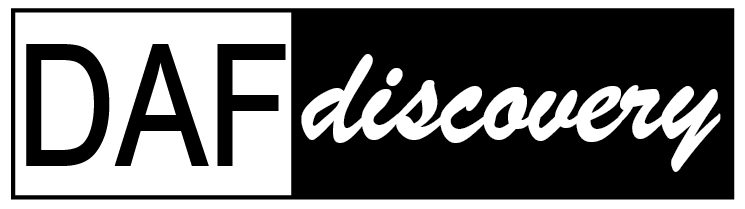

In [ ]:
Ordered_Samples = df_metadata['Samples'].values.tolist()
Ordered_HPLC_DAD_filename = df_metadata['ATTRIBUTE_localsampleid'].values.tolist()
Ordered_BioAct_filename = df_metadata['BioAct_filename'].values.tolist()
print('You are about to merge data from: HPLC-DAD + BioAct. Go for Option 3')
data_inuse = ['NMR', 'BioAct']

print(f'Data in Use: {data_inuse}')

In [ ]:
normalized_df_data = normalized_df.drop(["Chemical Shift (ppm)"], axis=1)
axis = normalized_df["Chemical Shift (ppm)"]
    
else: print('Try the next one')

# REORDERING data according to the Metadata (Ordered_Samples)

normalized_df_data = normalized_df_data[Ordered_HPLC_DAD_filename] # reorder columns according to the sampleIDs
normalized_df_data.rename(columns={i:j for i,j in zip(Ordered_HPLC_DAD_filename,Ordered_Samples)}, inplace=True) # rename column headers as sampleIDs

print('Data is reordered according to the Matadata.')

In [ ]:
# Chose driver to produce highlighted NMR spectra showing highly correlated peaks

%matplotlib notebook

# DRIVER FROM THE HPLC_DAD data
driver = 21.0

corr, covar = dp.STOCSY_LCDAD(driver, normalized_df_data, axis)
plt.show()


---

##### Thank you for using.

Feel free to contact us at ricardo_mborges@ufrj.br for doubts, ideas for next projects, or for collaborations. 

Check also:
* NMRfilter: Applying NMR compound identification using NMRfilter to match predicted to experimental data
    * https://link.springer.com/article/10.1007/s11306-020-01748-1
      
  
* DAFdiscovery: Data Fusion-based Discovery (DAFdiscovery) pipeline to aid compound annotation and bioactive compound discovery across diverse spectral data 
    * https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/abs/10.1002/pca.3178
      
  
* DBsimilarity: Data Base similarity (DBsimilarity) of natural products to aid compound identification on MS and NMR pipelines, similarity networking, and more
    * https://analyticalsciencejournals.onlinelibrary.wiley.com/doi/10.1002/pca.3277